## Assumptions:
* 256 MAC PEs at 1GHz means we can do 256 billion 32-bit MAC operations per second
* our MAC PEs are not optimized for more efficient computation when weights or activations are smaller
* ReLU function uses no MAC operations
* A MAC operation *is* a FLOP
* Memory overhead for feature maps is not to be considered as in that case then all bandwidths would be bounded by DRAM bandwidth
* Stride is always 2 (this produced the most interesting results)

# Credit
contains code modified from https://github.com/mohamed/roofline and https://github.com/JorgeG94/roofline_plot

## Declarations

In [155]:
import numpy
import matplotlib.pyplot
import matplotlib

START = -2
STOP = 6
N = abs(STOP - START + 1)

capacityWeightsSRAM = 128000 # bytes
capacityActivationSRAM = 2E6 # bytes

weightsAndActivationBits = 32 # bits. to start

layers = [{
    'name': "layer 1",
    'conv': True,
    'utilization': 1,
    'overSRAM': False,
    'filterHeight': 3,
    'filterWidth': 3,
    'inChannels': 3,
    'outChannels': 64,
    'inHeight': 256,
    'inWidth': 256,
    'outHeight': 0,
    'outWidth': 0,
    'bytes': 0,
    'MACs': 0
},
{
    'name': "layer 2",
    'conv': True,
    'overSRAM': False,
    'utilization': .77,
    'filterHeight': 1,
    'filterWidth': 7,
    'inChannels': 64,
    'outChannels': 64,
    'inHeight': 0,
    'inWidth': 0,
    'outHeight': 0,
    'outWidth': 0,
    'bytes': 0,
    'MACs': 0
},
{
    'name': "layer 3",
    'conv': True,
    'overSRAM': False,
    'utilization': .77,
    'filterHeight': 7,
    'filterWidth': 1,
    'inChannels': 64,
    'outChannels': 16,
    'inHeight': 0,
    'inWidth': 0,
    'outHeight': 0,
    'outWidth': 0,
    'bytes': 0,
    'MACs': 0
},
{
    'name': "layer 4",
    'conv': False,
    'overSRAM': False,
    'utilization': .89,
    'inChannels': 16,
    'outChannels': 16,
    'inHeight': 0,
    'inWidth': 0,
    'outHeight': 0,
    'outWidth': 0,
    'bytes': 0,
    'MACs': 0
}]

calculateLayers()

print(layers)



[{'name': 'layer 1', 'conv': True, 'utilization': 1, 'overSRAM': True, 'filterHeight': 3, 'filterWidth': 3, 'inChannels': 3, 'outChannels': 64, 'inHeight': 256, 'inWidth': 256, 'outHeight': 128, 'outWidth': 128, 'bytes': 6912.0, 'MACs': 442368}, {'name': 'layer 2', 'conv': True, 'overSRAM': False, 'utilization': 0.77, 'filterHeight': 1, 'filterWidth': 7, 'inChannels': 64, 'outChannels': 64, 'inHeight': 128, 'inWidth': 128, 'outHeight': 64, 'outWidth': 62, 'bytes': 114688.0, 'MACs': 1777664}, {'name': 'layer 3', 'conv': True, 'overSRAM': False, 'utilization': 0.77, 'filterHeight': 7, 'filterWidth': 1, 'inChannels': 64, 'outChannels': 16, 'inHeight': 64, 'inWidth': 62, 'outHeight': 30, 'outWidth': 32, 'bytes': 28672.0, 'MACs': 430080}, {'name': 'layer 4', 'conv': False, 'overSRAM': True, 'utilization': 0.89, 'inChannels': 16, 'outChannels': 16, 'inHeight': 30, 'inWidth': 32, 'outHeight': 16, 'outWidth': 16, 'bytes': 251658240.0, 'MACs': 62914560}]


## Functions

In [156]:

def calculateLayers():
    layers[0]['outHeight'] = calcOutputSize(layers[0]['inHeight'], filterSize = layers[0]['filterHeight'])
    layers[0]['outWidth'] = calcOutputSize(layers[0]['inWidth'], filterSize = layers[0]['filterWidth'])
    layers[0]['bytes'] = sizeInBytes(layers[0])
    layers[0]['MACs'] = numMAC(layers[0])
    layers[0]['overSRAM'] = isOverSRAM(layers[0])

    for index, layer in enumerate(layers[1 : ]):
        if layer['conv'] == False:
            filterHeight = 1
            filterWidth = 1
        else:
            filterHeight = layer['filterHeight']
            filterWidth = layer['filterWidth']

        layer['inHeight'] = layers[index]['outHeight']
        layer['inWidth'] = layers[index]['outWidth']

        layer['outHeight'] = calcOutputSize(layer['inHeight'], filterSize = filterHeight)
        layer['outWidth'] = calcOutputSize(layer['inWidth'], filterSize = filterWidth)

        layer['bytes'] = sizeInBytes(layer)
        layer['MACs'] = numMAC(layer)
        layer['overSRAM'] = isOverSRAM(layer)

def performance(peakPerformance, peakBandwidth, intensity):
    performance = numpy.zeros(len(intensity))
    performance = numpy.minimum(peakPerformance, peakBandwidth * intensity)
    return performance

def plotLines():
    axis.plot(arithIntensity, maxPerfWithDRAM, label='System max performance with DRAM use')
    axis.plot(arithIntensity, maxPerf, label='System max performance')
    axis.plot(arithIntensity, performance(systemMaxPerformance * .89, bandwidthSRAM, arithIntensity), label='at 89%% usage')
    axis.plot(arithIntensity, performance(systemMaxPerformance * .77, bandwidthSRAM, arithIntensity), label='at 77%% usage')

def finalizeGraph():
    axis.legend(loc='upper left', prop={'size': 9})
    fig.tight_layout()

def numMAC(layer):
    if layer['conv']:
        return layer['filterHeight'] * layer['filterWidth'] * layer['inChannels'] * layer['outHeight'] * layer['outWidth']
    else:
        return layer['inHeight'] * layer['inWidth'] * layer['outHeight'] * layer['outWidth'] * layer['inChannels'] * layer['outChannels']

def sizeInBytes(layer):
    if layer['conv']:
        return (layer['filterHeight'] * layer['filterWidth'] * layer['inChannels'] * layer['outChannels'] * weightsAndActivationBits) / 8
    else:
        return (layer['inHeight'] * layer['inWidth'] * layer['outHeight'] * layer['outWidth'] * layer['inChannels'] * layer['outChannels'] * weightsAndActivationBits) / 8

def calcOutputSize(inSize, filterSize = 1, stride = 2):
    return round((inSize - filterSize) / stride + 1)

def isOverSRAM(layer):
    return (layer['bytes'] > capacityWeightsSRAM) or (activationSizeBytes(layer) > capacityActivationSRAM)

def activationSizeBytes(layer):
    return layer['outHeight'] * layer['outWidth'] * layer['outChannels'] * weightsAndActivationBits / 8

def plotNetwork():
    networkBytes = 0
    networkMACs = 0
    networkActivationBytes = 0
    for layer in layers:
        networkBytes += layer['bytes']
        networkMACs += layer['MACs']
        networkActivationBytes += activationSizeBytes(layer)

    axis.axvline(networkMACs / (networkBytes + networkActivationBytes), label='entire network', linestyle='-', color=color[0])

def plotLayers():
    index = 1
    for layer in layers:
        axis.axvline(layer['MACs'] / (layer['bytes'] + activationSizeBytes(layer)), label=layer['name'], linestyle='-.', color=color[index])
        index += 1
        if layer['overSRAM']:
            print(layer['name'] + ' may have use too much memory for SRAM performance')
        else:
            print(layer['name'] + ' should be well within SRAM bounds')


layer 1 may have use too much memory for SRAM performance
layer 2 should be well within SRAM bounds
layer 3 should be well within SRAM bounds
layer 4 may have use too much memory for SRAM performance


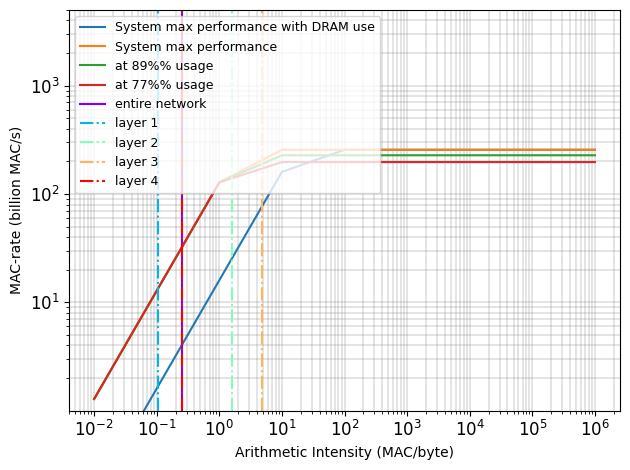

In [157]:
systemMaxPerformance = 256 # GFLOP/s
bandwidthSRAM = 128 # GB/s
bandwidthDRAM = 16 # GB/s

arithIntensity = numpy.logspace(START, STOP, num=N, base=10)

maxPerf = performance(systemMaxPerformance, bandwidthSRAM, arithIntensity)
maxPerfWithDRAM = performance(systemMaxPerformance, bandwidthDRAM, arithIntensity)

fig, axis = matplotlib.pyplot.subplots()
axis.set_xscale('log', base=10)
axis.set_yscale('log', base=10)
axis.set_xlabel('Arithmetic Intensity (MAC/byte)', fontsize=10)
axis.grid(True, which='both', color='gray', linestyle='-', linewidth=0.3)

matplotlib.pyplot.setp(axis, xticks=arithIntensity, yticks=numpy.logspace(1, 20, num=20, base=10))
matplotlib.pyplot.yticks(fontsize=12)
matplotlib.pyplot.xticks(fontsize=12)
axis.set_ylabel("MAC-rate (billion MAC/s)", fontsize=10)
axis.set_ylim(bottom=1, top=5000)

color = matplotlib.pyplot.cm.rainbow(numpy.linspace(0, 1, len(layers) + 1))

plotLines()
plotNetwork()
plotLayers()

finalizeGraph()

We see here that all are memory-bound

but what if we changed them to 16-bit float values?

layer 1 may have use too much memory for SRAM performance
layer 2 should be well within SRAM bounds
layer 3 should be well within SRAM bounds
layer 4 may have use too much memory for SRAM performance


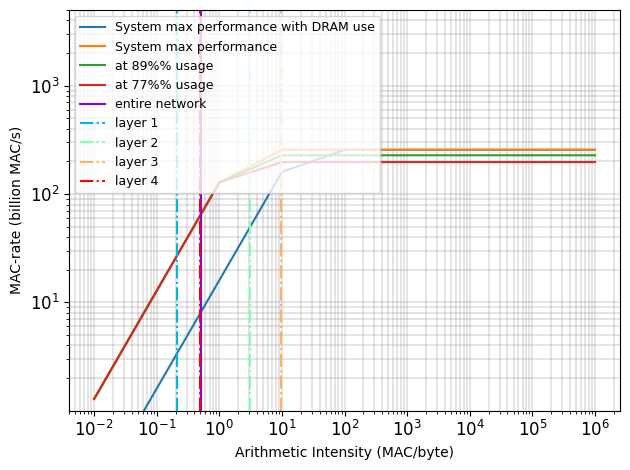

In [158]:
weightsAndActivationBits = 16

calculateLayers()

fig, axis = matplotlib.pyplot.subplots()
axis.set_xscale('log', base=10)
axis.set_yscale('log', base=10)
axis.set_xlabel('Arithmetic Intensity (MAC/byte)', fontsize=10)
axis.grid(True, which='both', color='gray', linestyle='-', linewidth=0.3)

matplotlib.pyplot.setp(axis, xticks=arithIntensity, yticks=numpy.logspace(1, 20, num=20, base=10))
matplotlib.pyplot.yticks(fontsize=12)
matplotlib.pyplot.xticks(fontsize=12)
axis.set_ylabel("MAC-rate (billion MAC/s)", fontsize=10)
axis.set_ylim(bottom=1, top=5000)

color = matplotlib.pyplot.cm.rainbow(numpy.linspace(0, 1, len(layers) + 1))

plotLines()
plotNetwork()
plotLayers()

finalizeGraph()

here we can see that layer 3 is very close to the inflection point and may be computationally-bound

and what if we quantized further to 4-bit?

layer 1 should be well within SRAM bounds
layer 2 should be well within SRAM bounds
layer 3 should be well within SRAM bounds
layer 4 may have use too much memory for SRAM performance


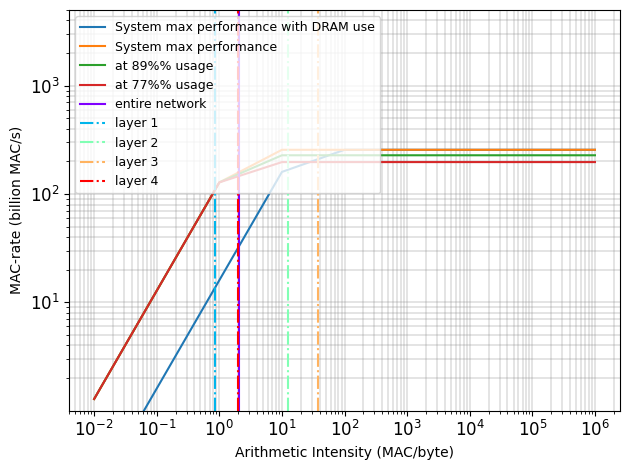

In [159]:
weightsAndActivationBits = 4

calculateLayers()

fig, axis = matplotlib.pyplot.subplots()
axis.set_xscale('log', base=10)
axis.set_yscale('log', base=10)
axis.set_xlabel('Arithmetic Intensity (MAC/byte)', fontsize=10)
axis.grid(True, which='both', color='gray', linestyle='-', linewidth=0.3)

matplotlib.pyplot.setp(axis, xticks=arithIntensity, yticks=numpy.logspace(1, 20, num=20, base=10))
matplotlib.pyplot.yticks(fontsize=12)
matplotlib.pyplot.xticks(fontsize=12)
axis.set_ylabel("MAC-rate (billion MAC/s)", fontsize=10)
axis.set_ylim(bottom=1, top=5000)

color = matplotlib.pyplot.cm.rainbow(numpy.linspace(0, 1, len(layers) + 1))

plotLines()
plotNetwork()
plotLayers()

finalizeGraph()

now we can see that layers 3 and 2 are both computationally bound

throughout it all, the system itself always remains memory-bound